# Shap explanation of RandomForest Classifier

A good overview of shap values and visuals for classification models following [Explaining Scikit-learn models with SHAP](https://towardsdatascience.com/explaining-scikit-learn-models-with-shap-61daff21b12a) by Zolzaya Luvsandorj. This demo is on RandomForest classification model, the next one will be on XGboost classification. 

In [2]:
import numpy as np
np.set_printoptions(formatter={'float':lambda x:"{:.4f}".format(x)})
import pandas as pd
pd.options.display.float_format = "{:.3f}".format
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='rainbow')
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, 
                              RandomForestClassifier)
import xgboost as xgb
import shap #v0.39.0
shap.initjs()

# Import sample data
df =  sns.load_dataset('titanic')
df['is_male'] = df['sex'].map({'male': 1, 'female': 0}) # Encode
# Keep numerical complete columns
df = df.select_dtypes('number').dropna() 
X = df.drop(columns=['survived'])
y = df['survived']
# Partition data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}\n")
print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")
display(X_train.head())
# Train a simple model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

Training features shape: (571, 6)
Training target shape: (571,)

Test features shape: (143, 6)
Test target shape: (143,)


,pclass,age,sibsp,parch,fare,is_male
830,3,15.000,1,0,14.454,0
565,3,24.000,2,0,24.150,1
148,2,36.500,0,2,26.000,1
105,3,28.000,0,0,7.896,1
289,3,22.000,0,0,7.750,0


RandomForestClassifier(random_state=42)

We can see from the results below that
* Just like regression shap_test.data will contain the same number of records as the X_test. 
* However, the dimension of `values` and `base_values` are different.

In [3]:
# get the explainer and create shap values
explainer = shap.Explainer(model)
shap_test = explainer(X_test)
print(f"Length of shap_test: {len(shap_test)}\n")
print(f"Sample shap_test for the first case:\n{shap_test[0]}")

Length of shap_test: 143

Sample shap_test for the first case:
.values =
array([[-0.1581, 0.1581],
       [-0.0367, 0.0367],
       [-0.0182, 0.0182],
       [-0.0059, 0.0059],
       [-0.0479, 0.0479],
       [-0.3006, 0.3006]])

.base_values =
array([0.5874, 0.4126])

.data =
array([1.0000, 15.0000, 0.0000, 1.0000, 211.3375, 0.0000])


In [4]:
shap_test.shape

(143, 6, 2)

## Base Value

The base value now tells us the probability for each class.


In [37]:
print(f"Expected value: {explainer.expected_value[1]:.2f}")
print(f"Average target value (training data): {y_train.mean():.2f}")
print(f"Base value: {shap_test.base_values[0][1]:.2f}")

Expected value: 0.41
Average target value (training data): 0.41
Base value: 0.41


## Shap Values
Shap values are also provided for both classes. We can tell from the results above that they are the negative of each other. It is easy to extract the shap values for positive class like this:

In [30]:
shap_test.values.shape

(143, 6, 2)

In [31]:
shap_test.values[1]

array([[0.1388, -0.1388],
       [-0.1082, 0.1082],
       [0.1739, -0.1739],
       [-0.0027, 0.0027],
       [0.1110, -0.1110],
       [0.0999, -0.0999]])

In [32]:
shap_df = pd.DataFrame(shap_test.values[:,:,1], 
                       columns=shap_test.feature_names, 
                       index=X_test.index)
shap_df

,pclass,age,sibsp,parch,fare,is_male
689,0.158,0.037,0.018,0.006,0.048,0.301
278,-0.139,0.108,-0.174,0.003,-0.111,-0.100
506,0.111,0.002,0.023,-0.010,-0.010,0.350
9,0.081,0.045,0.015,-0.009,0.005,0.351
494,-0.102,-0.092,-0.003,-0.017,-0.071,-0.118
...,...,...,...,...,...,...
581,0.165,-0.016,0.019,-0.000,0.103,0.306
44,-0.157,-0.019,-0.004,-0.038,-0.126,0.252
234,-0.043,-0.074,0.003,-0.020,-0.042,-0.222
781,0.163,-0.001,0.015,-0.005,0.093,0.293


Like in regression before, adding up shap values and the base values shoud give us the predicted value, which is confirmed below. 

In [34]:
np.isclose(model.predict_proba(X_test)[:,1], 
           explainer.expected_value[1] + shap_df.sum(axis=1))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## Shap Built-in Plots

### Global | Feature Importance

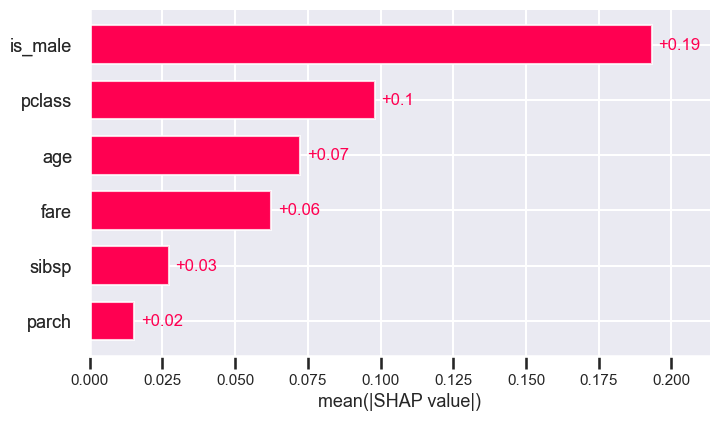

In [35]:
shap.plots.bar(shap_test[:, :,1])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


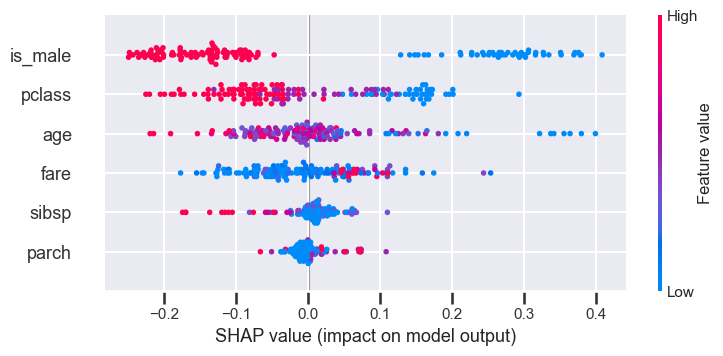

In [5]:
shap.summary_plot(shap_test[:,:,1])

### Local | Waterfall

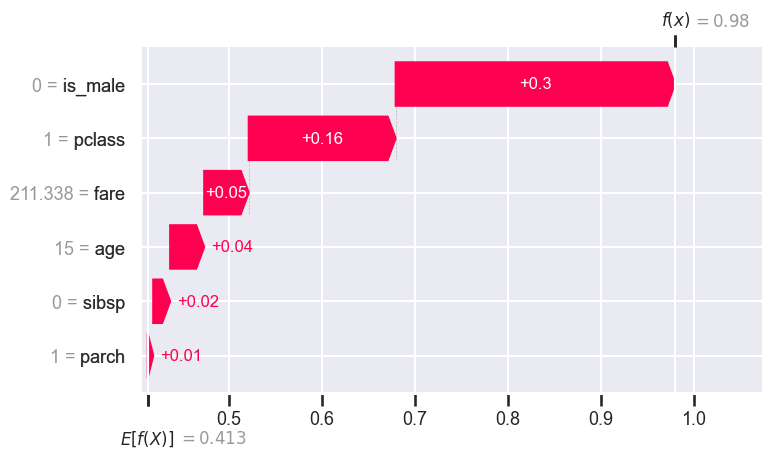

In [36]:
shap.plots.waterfall(shap_test[:,:,1][0])